decoy = 1
alpha = 1 + (self.alpha - 1.0) * decoy to samo dla ety
jesli chodzi nieperfekcyjną pamięc to wlasnie chodzi o zmiane tego decoy np 1, 0.95, 0.9, bedzie trzeba pokazac jak sie realizuje zapominanie w kodzie, srednia wykladnicza, w pewnym momencie mamy alpha_n i beta_n potem mamy alpha_n+1 = alpha_n + good,
beta_n+1 = beta_n + (1 - good)
wiec ostatecznie
alpa_n+1 = gamma (wspolczynnik pamietania) * alpha_n + ( 1 - gamma) * alpha_n+1
analogcziny wzor dla bety

wykres procent widgetow w czasie do wyprodukowanych


In [194]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist  # Renamed to avoid name collision
import random

random.seed(42)

NUMBER_OF_SYSTEMS = 10001 # Up to 10000
QUALITIES = [0.1, 0.2, 0.8, 0.9] # 4 Batches with different qualities
CHECKPOINTS = [1, 2, 3, 10, 20, 50, 100, 250, 500, 1000, 5000, 10000]
BEST_QUALITY = max(QUALITIES)


class Batch:
    """
    Represents a single manufacturer's batch with an unknown quality.
    """
    def __init__(self, true_quality, gamma=1.0):
        """
        Initialize a batch with a specific (hidden) quality.

        Args:
            true_quality (float): The true probability of success (0.0 to 1.0).
        """
        self.quality = true_quality
        self.gamma = gamma

        # Belief state (Beta Distribution parameters)
        # alpha=1, beta=1 implies a Uniform Prior (we know nothing initially)
        self.alpha = 1
        self.beta = 1

    def sample_belief(self):
        """
        Draws a random sample from the current estimated Beta distribution.
        """
        return np.random.beta(self.alpha, self.beta)

    def produce_and_test(self):
        """
        Simulates using one component from this batch.

        Returns:
            bool: True if success, False if lemon.
        """
        is_good = np.random.rand() < self.quality
        joutcome = int(is_good)

        old_alpha = self.alpha
        old_beta  = self.beta

        # Bayesian update
        new_alpha = old_alpha + int(is_good)
        new_beta  = old_beta + (1 - int(is_good))

        # Smoothed update
        self.alpha = self.gamma * old_alpha + (1 - self.gamma) * new_alpha
        self.beta  = self.gamma * old_beta  + (1 - self.gamma) * new_beta

        return is_good

        # # 1. The physical reality (Bernoulli trial)
        # is_good = np.random.rand() < self.quality
        # outcome = int(is_good)
        #
        # # 2. The Slow Learning Update
        # # Instead of adding 1.0, we add (1 - gamma).
        # # If gamma is 0.99, we add 0.01 per observation.
        # learning_rate = 1.0 - self.gamma
        #
        # self.alpha += outcome * learning_rate
        # self.beta += (1 - outcome) * learning_rate
        #
        # return is_good
    def get_empirical_success_ratio(self) -> float:
        """
        Helper method to get success ratio for ranking

        Returns:
            float: Success ratio
        """
        # total = (self.alpha - 1) + (self.beta - 1)
        # # Default
        # if total == 0:
        #     return 0.5
        # return (self.alpha - 1) / total
        # We subtract the prior (1.0) to see only the evidence
        evidence_alpha = self.alpha - 1.0
        evidence_beta = self.beta - 1.0
        total_evidence = evidence_alpha + evidence_beta

        if total_evidence <= 0.0001:
            return 0.5

        return evidence_alpha / total_evidence

class Factory:
    """
    Manages multiple batches and selects them based on a strategy.
    """
    def __init__(self, qualities):
        # Create Batch objects for each quality level
        self.batches = [Batch(q, 0.8) for q in qualities]
        self.total_systems = 0
        self.total_good = 0

        # Track total choices per batchso {0: count, 1: count ...}
        self.batch_selection_counts = {i: 0 for i in range(len(qualities))}
        self.batch_selection_history  = {i: [] for i in range(len(qualities))}

        # Track total choices per element
        self.el_quality_history = []
        self.el_optimal_quality_history = []

        self.current_lemon_idx = 0 # For Lemon strategy
        self.planning_queue = [] # For rank/ratio strategies

        self.EPSILON = 0.1 # 10% chance to explore


    def produce_system(self, select_sample="thompson"):
        """
        Selects a sample from a batch and produces a system.

        Possible methods of sample selection: "thompson", "lemon", "rank_n", "rank_ratio", "greedy", "upper_conf_bound"
        """

        chosen_index = 0

        # thompson
        if select_sample == "thompson":
            guessed_qualities = [b.sample_belief() for b in self.batches]

            # Pick the batch with the highest guess
            chosen_index = np.argmax(guessed_qualities)

        elif select_sample == "lemon": # shift after failure
            # We simply pick the current index
            chosen_index = self.current_lemon_idx

        elif select_sample in ["rank_n", "rank_ratio"]:

            # if the queue is empty, we plan a next cycle
            if not self.planning_queue:
                # Creating tuples of (index, batch) to keep track of IDs after sorting
                indexed_batches = list(enumerate(self.batches))

                if select_sample == "rank_n":
                    # Sorting from best to worst
                    sorted_batches = sorted(indexed_batches, key=lambda x: x[1].get_empirical_success_ratio(), reverse=True)
                    N = len(self.batches)

                    # Best gets N, next N-1
                    for rank, (original_idx, batch) in enumerate(sorted_batches):
                        count = N - rank
                        self.planning_queue.extend([original_idx] * count)

                elif select_sample == "rank_ratio":
                    # Sorting from worst to best
                    sorted_batches = sorted(indexed_batches, key=lambda x: x[1].get_empirical_success_ratio(), reverse=False)

                    # First worst gets 1
                    prev_amount = 1
                    self.planning_queue.extend([sorted_batches[0][0]] * prev_amount)

                    # Next ones depend on ratio
                    for i in range(1, len(sorted_batches)):
                        curr_idx, curr_batch = sorted_batches[i]
                        prev_idx, prev_batch = sorted_batches[i-1]

                        s_curr = curr_batch.get_empirical_success_ratio()
                        s_prev = prev_batch.get_empirical_success_ratio()

                        # Avoid division by zero
                        if s_prev <= 0.001: ratio = 1
                        else: ratio = s_curr / s_prev

                        amount = int(round(ratio * prev_amount))
                        amount = max(1, amount)

                        self.planning_queue.extend([curr_idx] * amount)
                        prev_amount = amount

            # Pop the next scheduled batch
            chosen_index = self.planning_queue.pop(0)

        elif select_sample == "greedy":
            if np.random.random() < self.EPSILON:
                # pick randomly
                chosen_index = np.random.randint(0, len(self.batches))
            else:
                ratio = [b.get_empirical_success_ratio() for b in self.batches]
                chosen_index = np.argmax(ratio)

        elif select_sample == "upper_conf_bound":

            unexplored = [i for i, count in self.batch_selection_counts.items() if count == 0]
            if unexplored:
                chosen_index = unexplored[0]
            else:
                # Formula: Average + sqrt(2  * ln(total_systems) / times_selected)
                ucb_values = []
                t = self.total_systems + 1
                for i, batch in enumerate(self.batches):
                    count = self.batch_selection_counts[i]

                    # # If batch hasn't been selected
                    # if count == 0:
                    #     chosen_index = 1
                    #     ucb_values = None
                    #     break

                    average_reward = batch.get_empirical_success_ratio()

                    # the curiosity bonus
                    bonus = np.sqrt((2 * np.log(self.total_systems)) / count)

                    ucb_values.append(average_reward + bonus)

                # if ucb_values is not None:
                #     chosen_index = np.argmax(ucb_values)

        # Update counts
        self.batch_selection_counts[chosen_index] += 1

        # Store history of counts
        for i in range(len(self.batches)):
            self.batch_selection_history[i].append(self.batch_selection_counts[i])

        chosen_batch = self.batches[chosen_index]

        # Produce and update that specific batch
        result = chosen_batch.produce_and_test()

        # Update for lemon strategy
        if select_sample == "lemon":
            if not result: # if I het lemon
                # Move to the next batch
                self.current_lemon_idx = (self.current_lemon_idx + 1) % len(self.batches)

        # Store quality of chosen
        self.el_quality_history.append(result)

        # We simulate theoretical choosing best probability 0.9
        optimal_reward = 1 if np.random.random() < BEST_QUALITY else 0
        self.el_optimal_quality_history.append(optimal_reward)

        # Update factory stats
        self.total_systems += 1
        self.total_good += int(result)

        return result

# Reproduce examples from the lecture

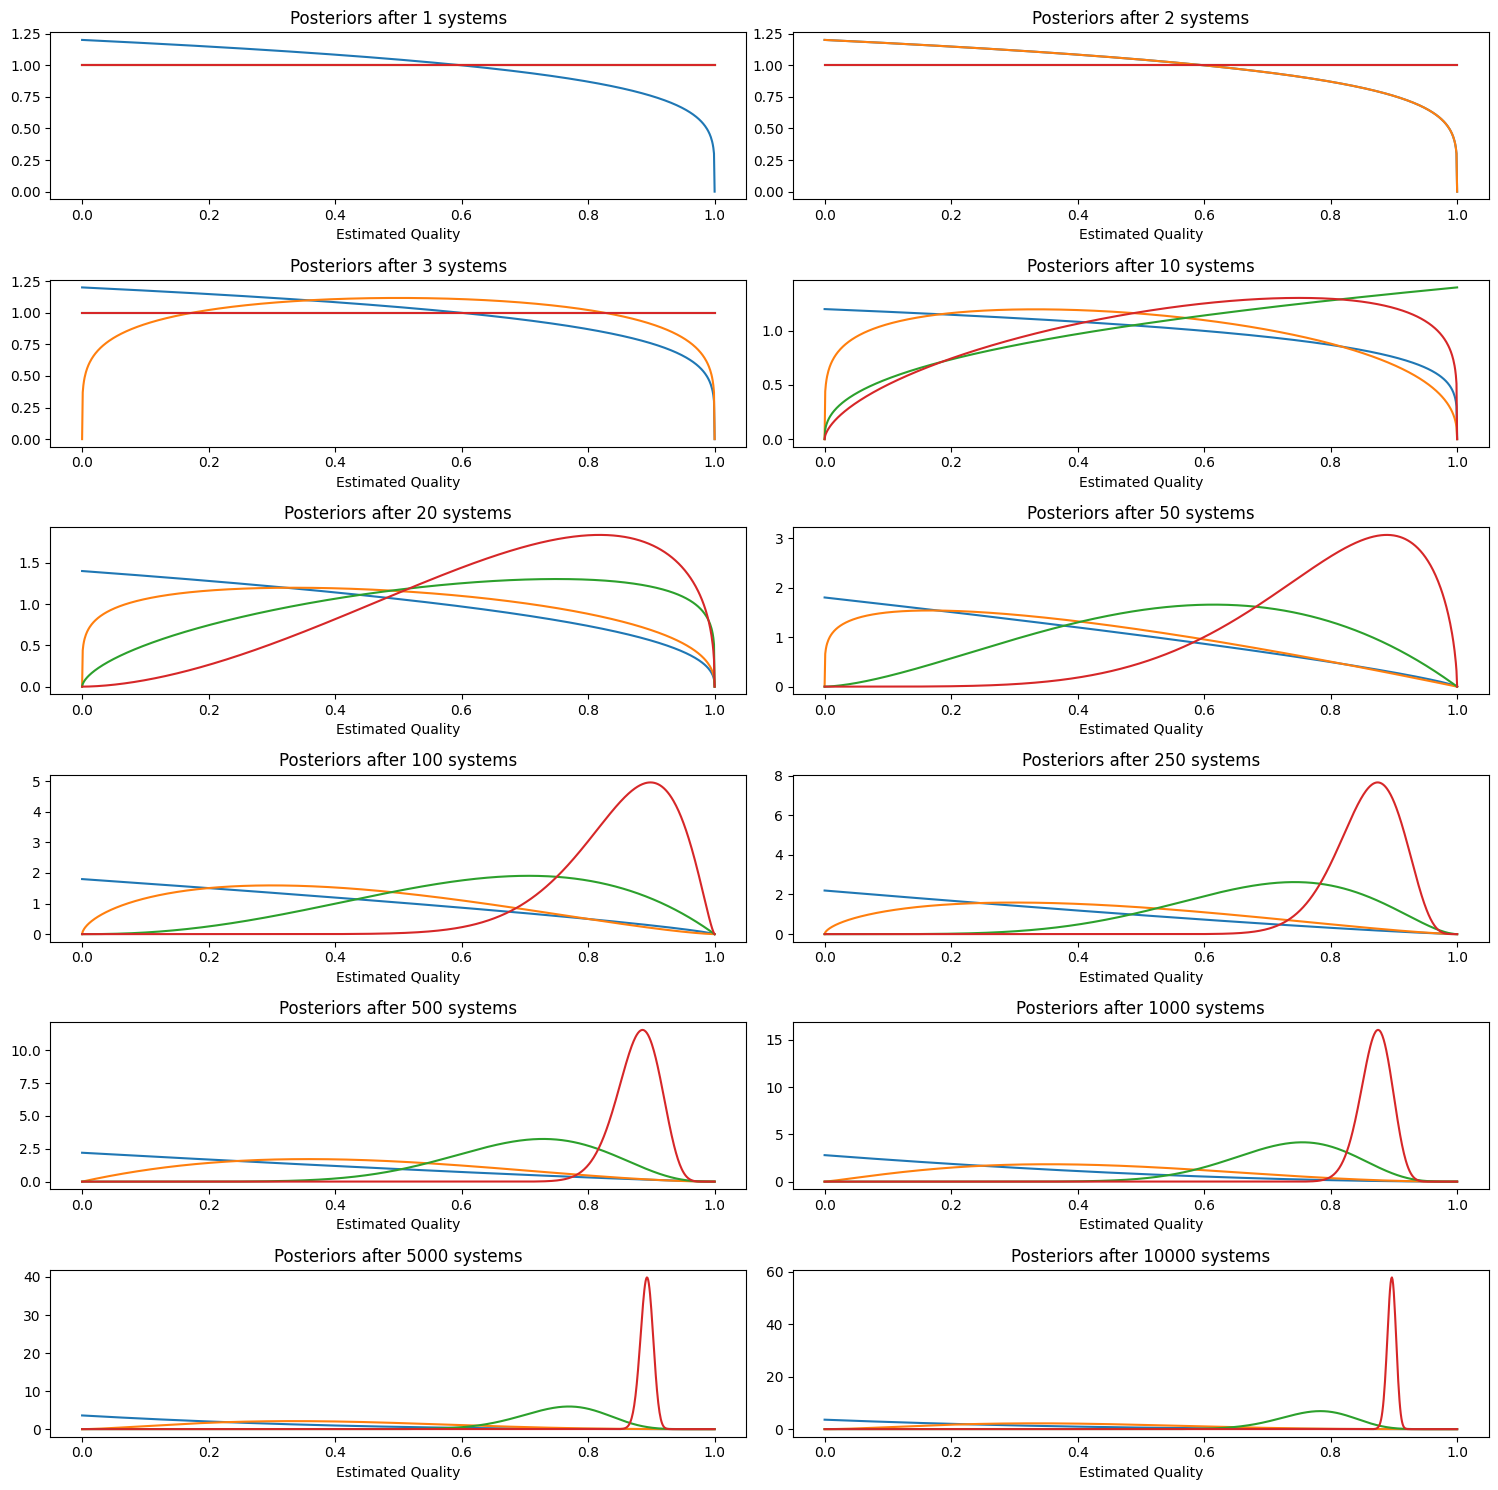

In [195]:
STRATEGY_TO_USE = "thompson"

# Initialize Factory
factory = Factory(QUALITIES)

# Prepare Plotting
fig, axes = plt.subplots(6, 2, figsize=(15, 15))
axes = axes.flatten() # Flatten 6x2 matrix to a 1D array for easy indexing
plot_idx = 0
x_axis = np.linspace(0, 1, 1000) # probability


for system_idx in range(1, NUMBER_OF_SYSTEMS + 1):

    factory.produce_system(STRATEGY_TO_USE)

    # Check if we have to draw
    if system_idx in CHECKPOINTS:
        ax = axes[plot_idx]

        # Plot the Beta for each batch
        for i, batch in enumerate(factory.batches):
            # Calculate the curve
            y_axis = beta_dist.pdf(x_axis, batch.alpha, batch.beta)

            # Plot with a label
            ax.plot(x_axis, y_axis, label=f'Batch {i+1} (True: {batch.quality})')


        ax.set_title(f"Posteriors after {system_idx} systems")
        ax.set_xlabel("Estimated Quality")

        plot_idx += 1

plt.tight_layout()
plt.show()

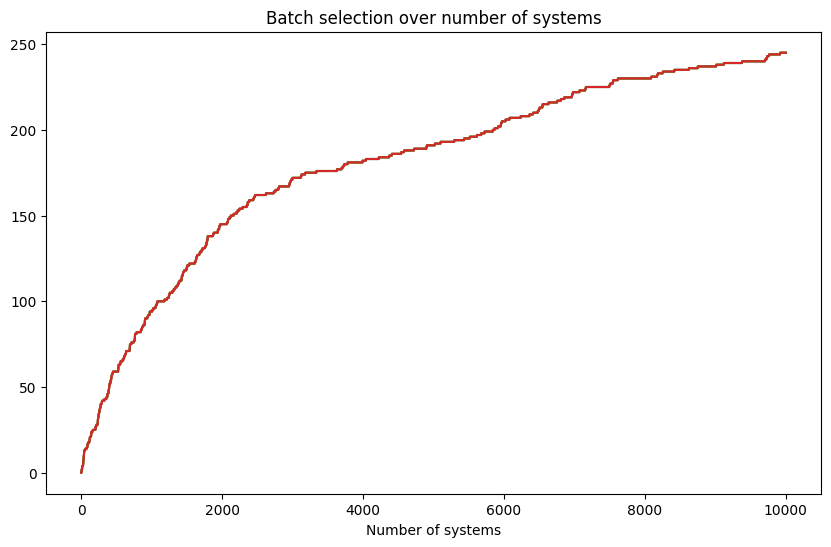

In [196]:
# If there is a diagram 'Batch selection per Bayesian choice minus per optimal choice' If I interpreted it well optimal batch should be chosen always but due to randomness
# optimal one is not always but most of it, but we want count how many times were optimal one chosen
x = np.linspace(0, NUMBER_OF_SYSTEMS, 10001)
plt.figure(figsize=(10,6))
for i, history in factory.batch_selection_history.items():
    plt.plot(x, factory.batch_selection_history[2])
plt.xlabel("Number of systems")
plt.title("Batch selection over number of systems")
plt.show()


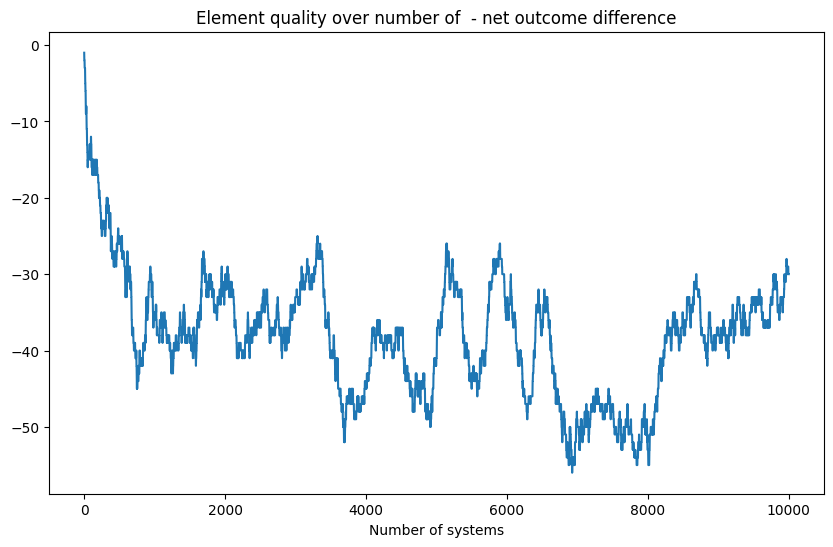

In [197]:
bayesian_outcomes = np.array(factory.el_quality_history)
optimal_outcomes = np.array(factory.el_optimal_quality_history)
diff = bayesian_outcomes - optimal_outcomes

cumulative_diff = np.cumsum(diff)

plt.figure(figsize=(10,6))
plt.plot(cumulative_diff)
plt.xlabel("Number of systems")
plt.title("Element quality over number of  - net outcome difference")
plt.show()

# If a batch returns a 'lemon' select the next batch.

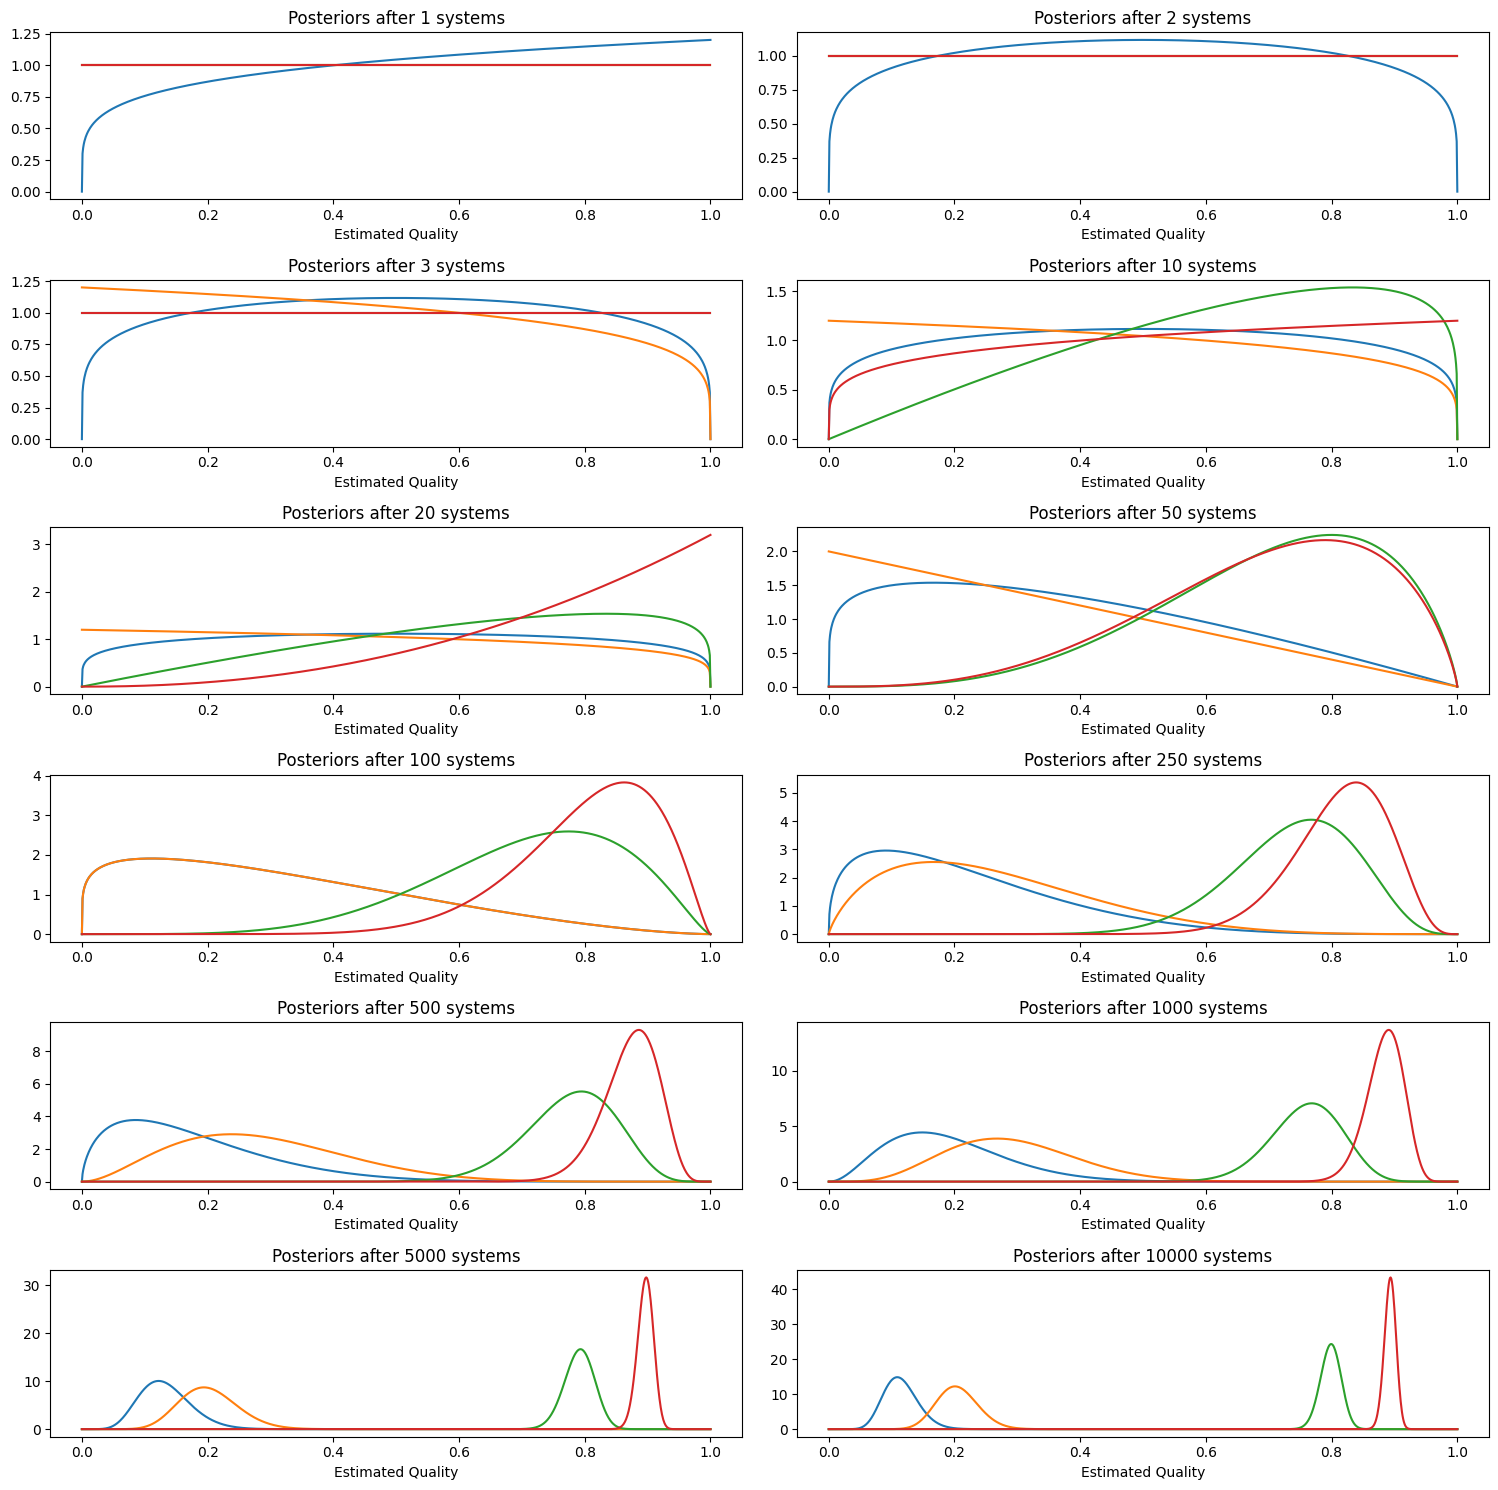

In [198]:
STRATEGY_TO_USE = "lemon"

# Initialize Factory
factory_lemon = Factory(QUALITIES)

# Prepare Plotting
fig, axes = plt.subplots(6, 2, figsize=(15, 15))
axes = axes.flatten() # Flatten 6x2 matrix to a 1D array for easy indexing
plot_idx = 0
x_axis = np.linspace(0, 1, 1000) # probability


for system_idx in range(1, NUMBER_OF_SYSTEMS + 1):

    factory_lemon.produce_system(STRATEGY_TO_USE)

    # Check if we have to draw
    if system_idx in CHECKPOINTS:
        ax = axes[plot_idx]

        # Plot the Beta for each batch
        for i, batch in enumerate(factory_lemon.batches):
            # Calculate the curve
            y_axis = beta_dist.pdf(x_axis, batch.alpha, batch.beta)

            # Plot with a label
            ax.plot(x_axis, y_axis, label=f'Batch {i+1} (True: {batch.quality})')


        ax.set_title(f"Posteriors after {system_idx} systems")
        ax.set_xlabel("Estimated Quality")

        plot_idx += 1

plt.tight_layout()
plt.show()

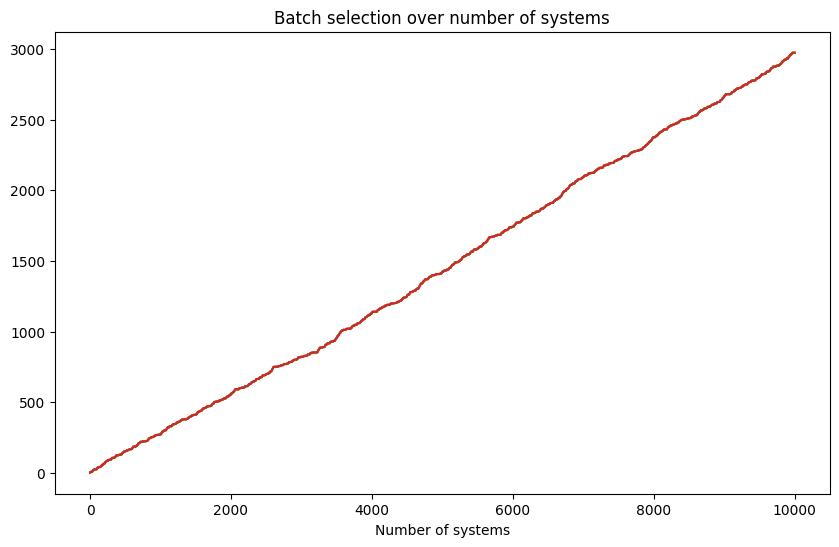

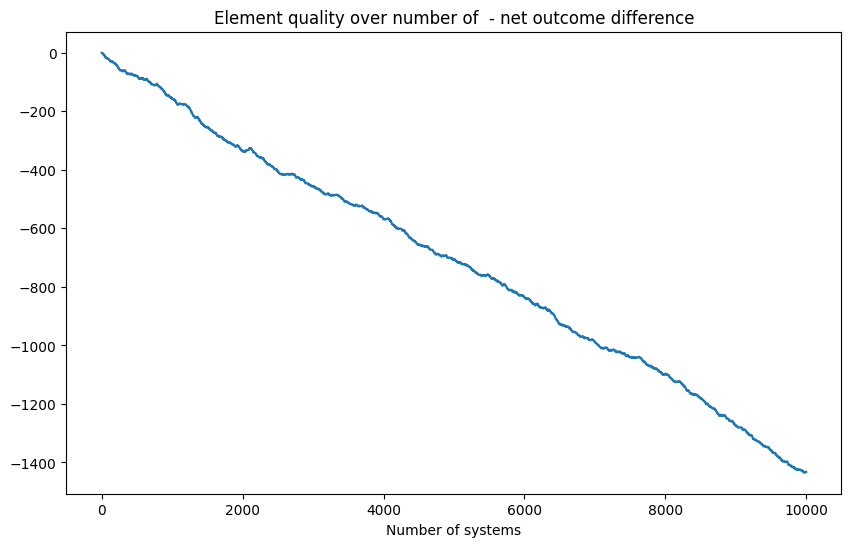

In [199]:
# If there is a diagram 'Batch selection per Bayesian choice minus per optimal choice' If I interpreted it well optimal batch should be chosen always but due to randomness
# optimal one is not always but most of it, but we want count how many times were optimal one chosen
x = np.linspace(0, NUMBER_OF_SYSTEMS, 10001)
plt.figure(figsize=(10,6))
for i, history in factory_lemon.batch_selection_history.items():
    plt.plot(x, factory_lemon.batch_selection_history[2])
plt.xlabel("Number of systems")
plt.title("Batch selection over number of systems")
plt.show()

bayesian_outcomes = np.array(factory_lemon.el_quality_history)
optimal_outcomes = np.array(factory_lemon.el_optimal_quality_history)
diff = bayesian_outcomes - optimal_outcomes

cumulative_diff = np.cumsum(diff)

plt.figure(figsize=(10,6))
plt.plot(cumulative_diff)
plt.xlabel("Number of systems")
plt.title("Element quality over number of  - net outcome difference")
plt.show()

# Rank the N batches from best to worst based on their success ratio, select N elements from best, N-1 from the next one etc.

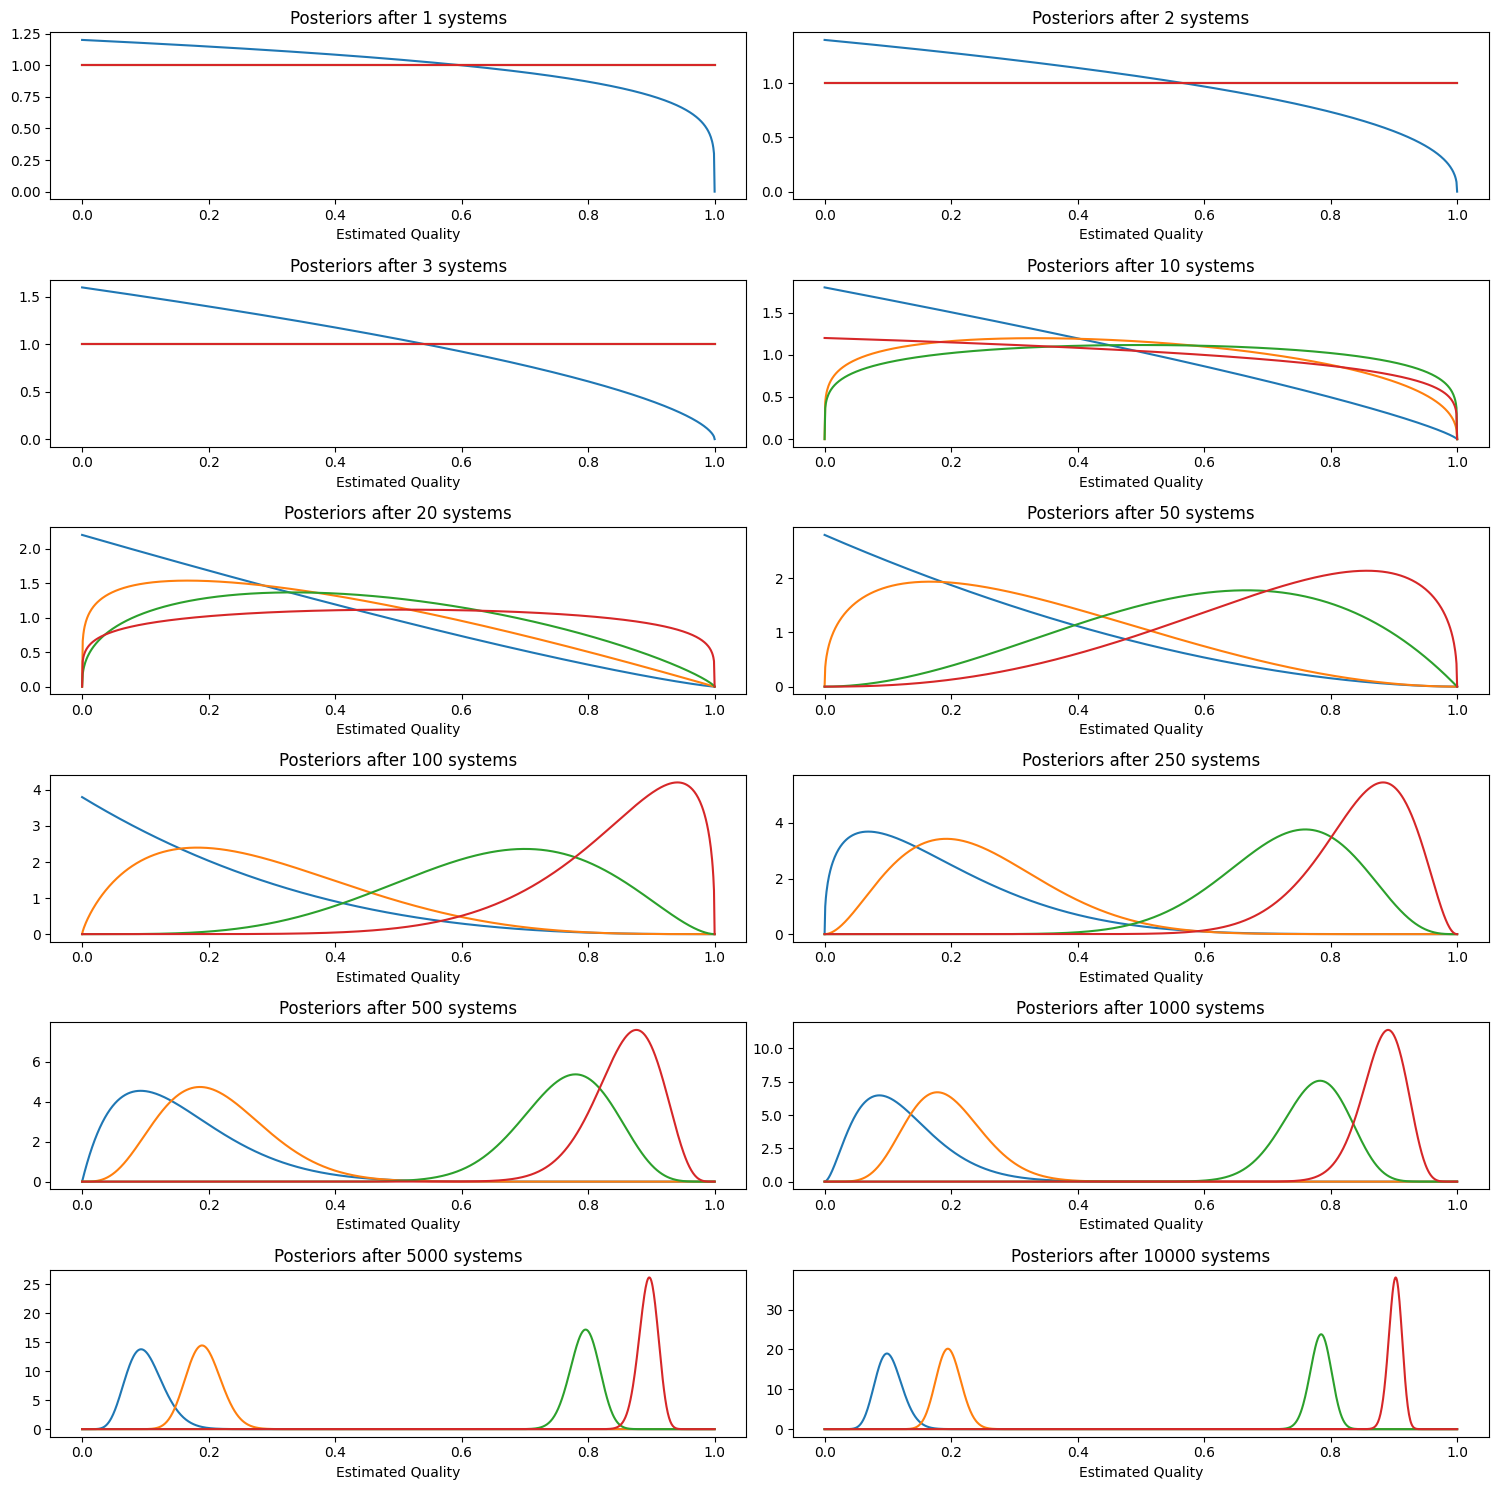

In [200]:
STRATEGY_TO_USE = "rank_n"

# Initialize Factory
factory_rank = Factory(QUALITIES)

# Prepare Plotting
fig, axes = plt.subplots(6, 2, figsize=(15, 15))
axes = axes.flatten() # Flatten 6x2 matrix to a 1D array for easy indexing
plot_idx = 0
x_axis = np.linspace(0, 1, 1000) # probability


for system_idx in range(1, NUMBER_OF_SYSTEMS + 1):

    factory_rank.produce_system(STRATEGY_TO_USE)

    # Check if we have to draw
    if system_idx in CHECKPOINTS:
        ax = axes[plot_idx]

        # Plot the Beta for each batch
        for i, batch in enumerate(factory_rank.batches):
            # Calculate the curve
            y_axis = beta_dist.pdf(x_axis, batch.alpha, batch.beta)

            # Plot with a label
            ax.plot(x_axis, y_axis, label=f'Batch {i+1} (True: {batch.quality})')


        ax.set_title(f"Posteriors after {system_idx} systems")
        ax.set_xlabel("Estimated Quality")

        plot_idx += 1

plt.tight_layout()
plt.show()

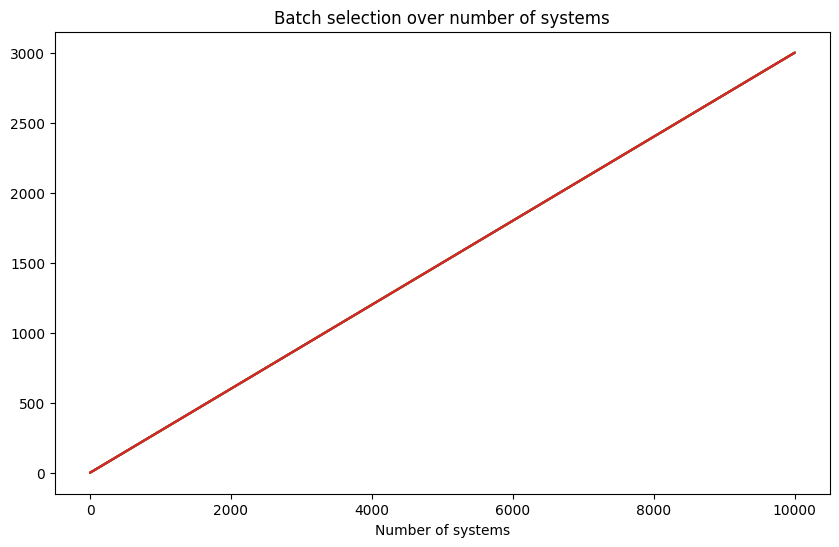

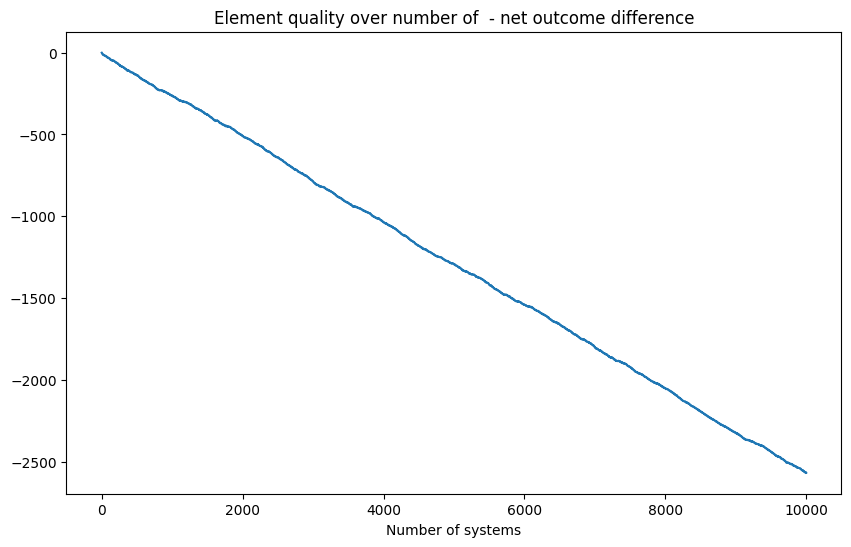

In [201]:
# If there is a diagram 'Batch selection per Bayesian choice minus per optimal choice' If I interpreted it well optimal batch should be chosen always but due to randomness
# optimal one is not always but most of it, but we want count how many times were optimal one chosen
x = np.linspace(0, NUMBER_OF_SYSTEMS, 10001)
plt.figure(figsize=(10,6))
for i, history in factory_rank.batch_selection_history.items():
    plt.plot(x, factory_rank.batch_selection_history[2])
plt.xlabel("Number of systems")
plt.title("Batch selection over number of systems")
plt.show()

bayesian_outcomes = np.array(factory_rank.el_quality_history)
optimal_outcomes = np.array(factory_rank.el_optimal_quality_history)
diff = bayesian_outcomes - optimal_outcomes

cumulative_diff = np.cumsum(diff)

plt.figure(figsize=(10,6))
plt.plot(cumulative_diff)
plt.xlabel("Number of systems")
plt.title("Element quality over number of  - net outcome difference")
plt.show()

# Rank the N batches from worst to best based on their success ratio s_i, compute ratio of success ratios of neighbouring batches r_i = s_i / s_i-1. Select 1 element from the worst, then from each next batch r_i times the amount of the previous batch.

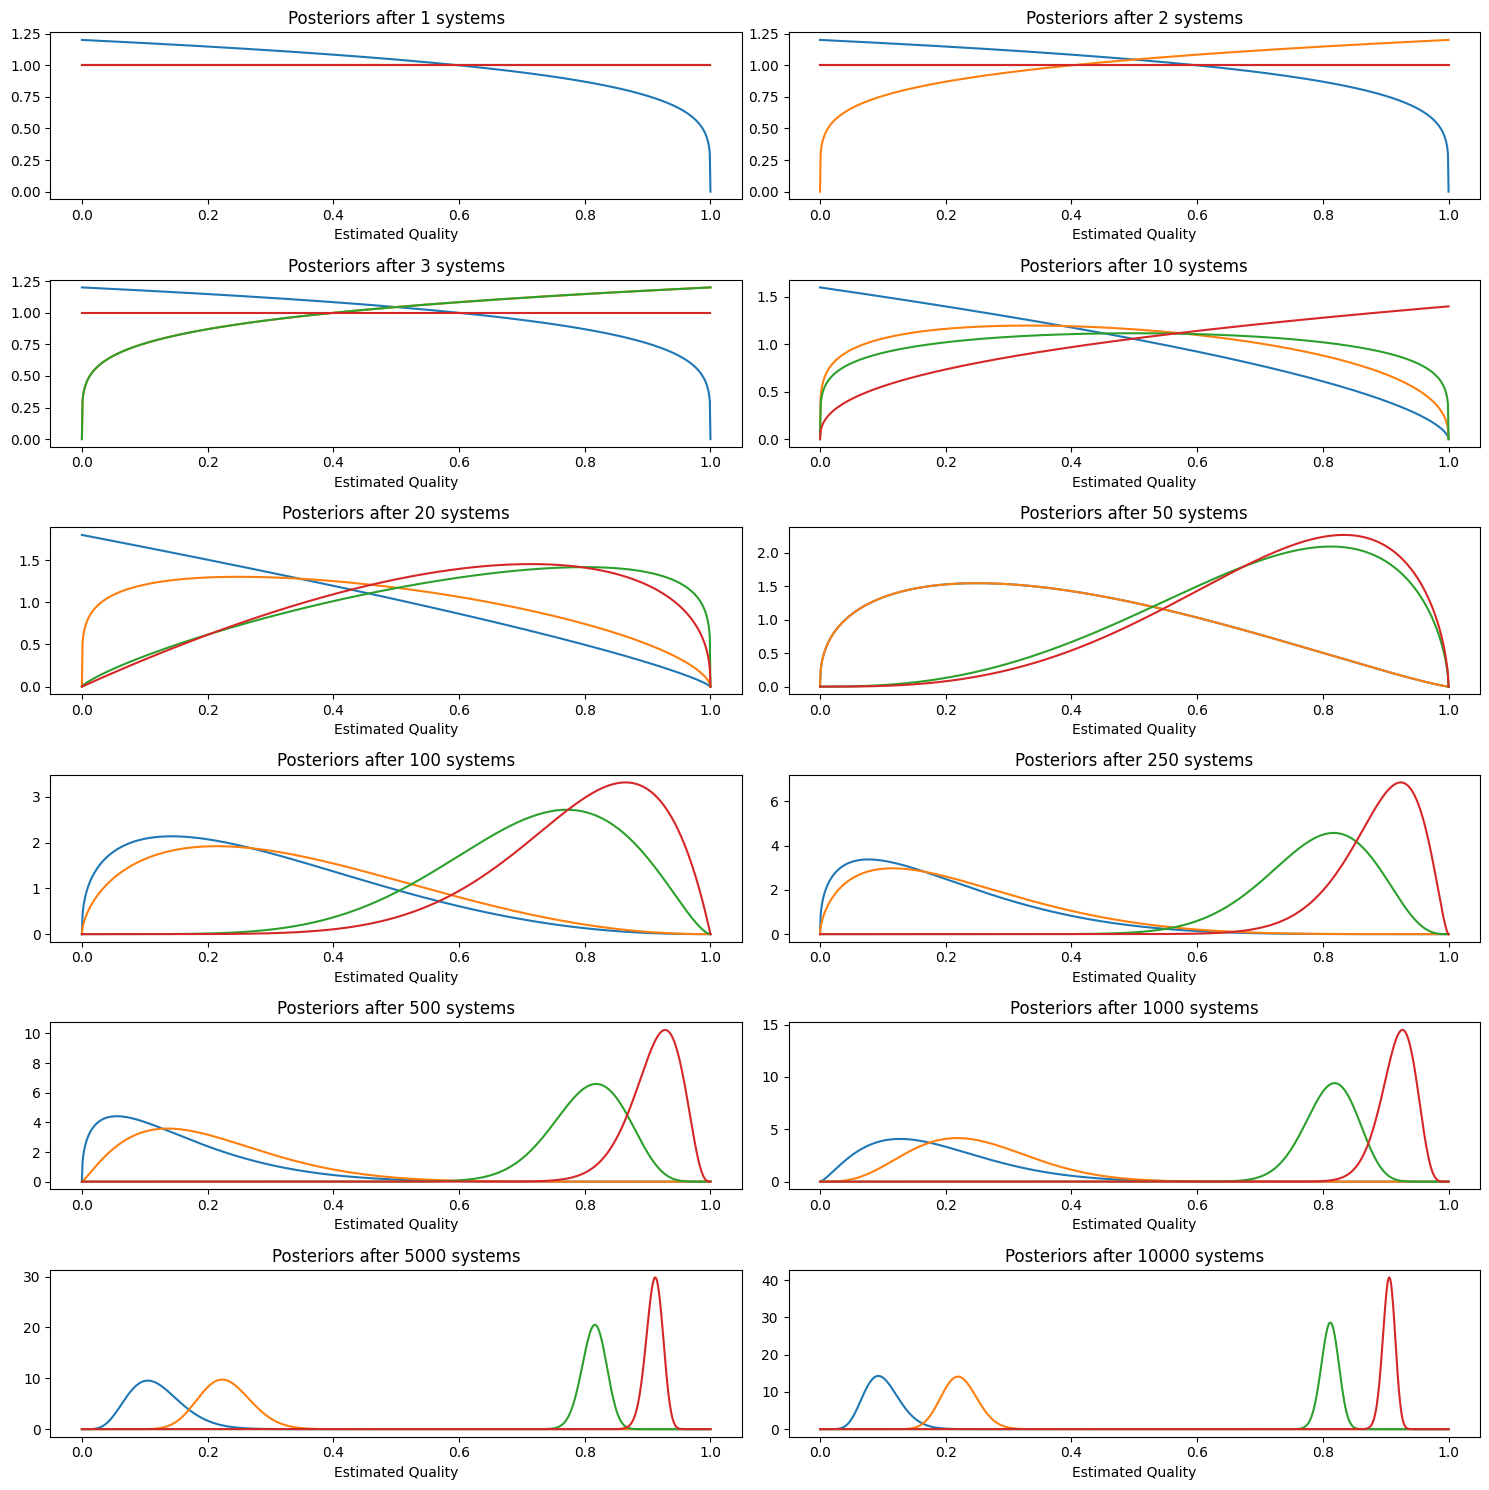

In [202]:
STRATEGY_TO_USE = "rank_ratio"

# Initialize Factory
factory_ratio = Factory(QUALITIES)

# Prepare Plotting
fig, axes = plt.subplots(6, 2, figsize=(15, 15))
axes = axes.flatten() # Flatten 6x2 matrix to a 1D array for easy indexing
plot_idx = 0
x_axis = np.linspace(0, 1, 1000) # probability


for system_idx in range(1, NUMBER_OF_SYSTEMS + 1):

    factory_ratio.produce_system(STRATEGY_TO_USE)

    # Check if we have to draw
    if system_idx in CHECKPOINTS:
        ax = axes[plot_idx]

        # Plot the Beta for each batch
        for i, batch in enumerate(factory_ratio.batches):
            # Calculate the curve
            y_axis = beta_dist.pdf(x_axis, batch.alpha, batch.beta)

            # Plot with a label
            ax.plot(x_axis, y_axis, label=f'Batch {i+1} (True: {batch.quality})')


        ax.set_title(f"Posteriors after {system_idx} systems")
        ax.set_xlabel("Estimated Quality")

        plot_idx += 1

plt.tight_layout()
plt.show()

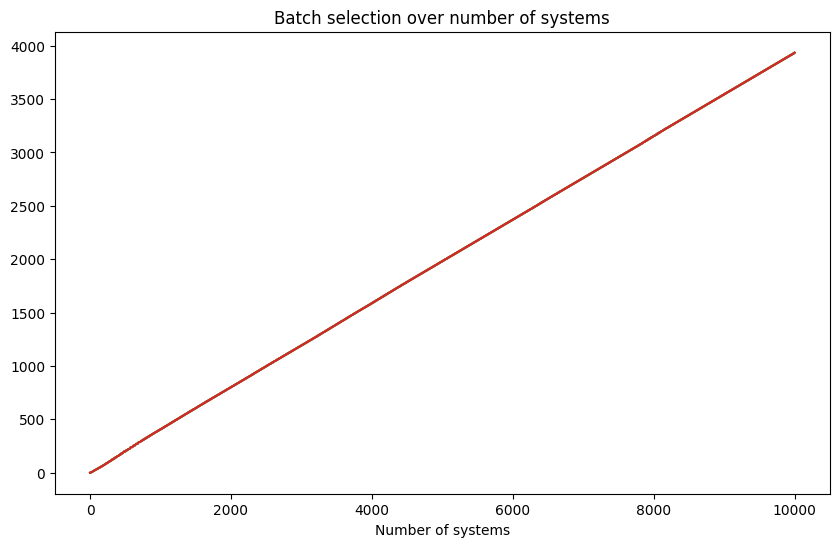

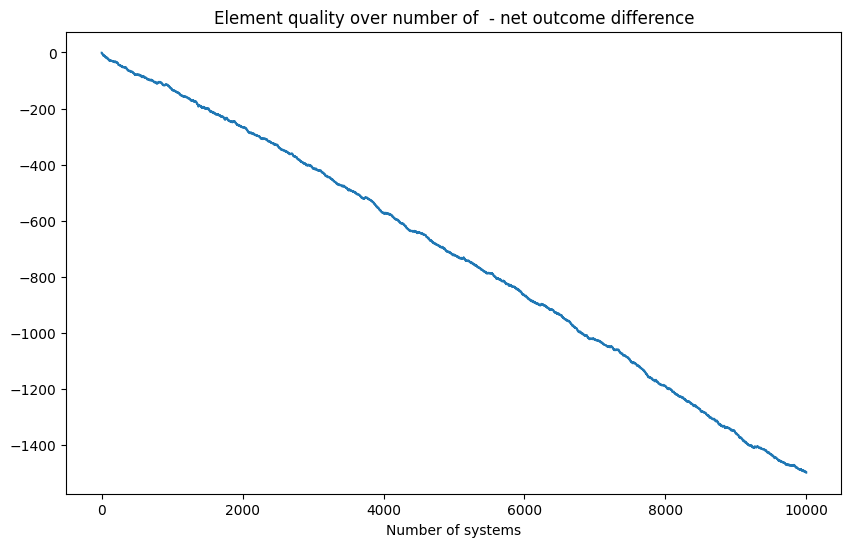

In [203]:
# If there is a diagram 'Batch selection per Bayesian choice minus per optimal choice' If I interpreted it well optimal batch should be chosen always but due to randomness
# optimal one is not always but most of it, but we want count how many times were optimal one chosen
x = np.linspace(0, NUMBER_OF_SYSTEMS, 10001)
plt.figure(figsize=(10,6))
for i, history in factory_ratio.batch_selection_history.items():
    plt.plot(x, factory_ratio.batch_selection_history[2])
plt.xlabel("Number of systems")
plt.title("Batch selection over number of systems")
plt.show()

bayesian_outcomes = np.array(factory_ratio.el_quality_history)
optimal_outcomes = np.array(factory_ratio.el_optimal_quality_history)
diff = bayesian_outcomes - optimal_outcomes

cumulative_diff = np.cumsum(diff)

plt.figure(figsize=(10,6))
plt.plot(cumulative_diff)
plt.xlabel("Number of systems")
plt.title("Element quality over number of  - net outcome difference")
plt.show()

# Difference between them

Lemon doesn't care about results it will be switching every time the lemon will pop.
Rank_n it every cycle it must test the worst batch so it is wasting time for bad ones
Rank ratio is worse than thompson but better then Rank N.

# Greedy method

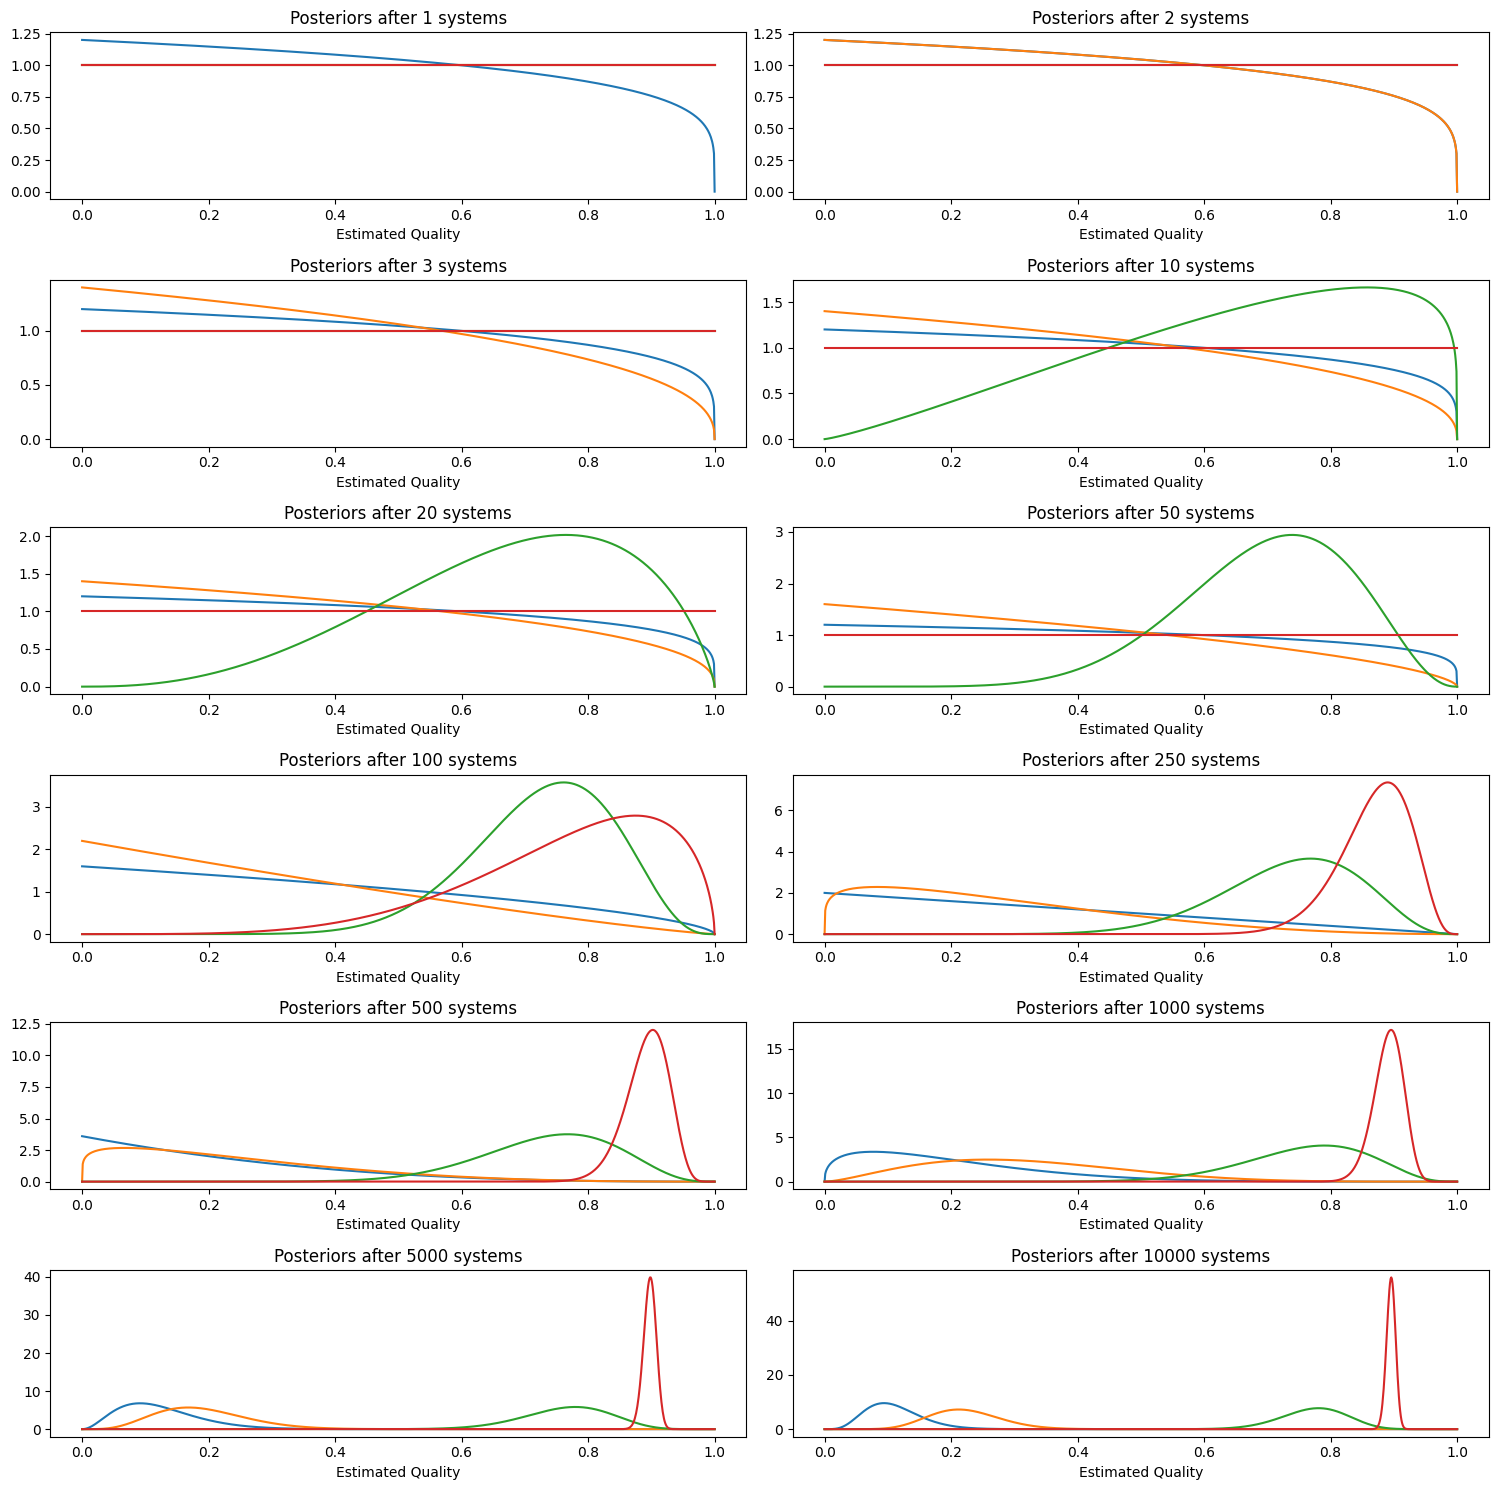

In [204]:
STRATEGY_TO_USE = "greedy"

# Initialize Factory
factory_greedy = Factory(QUALITIES)

# Prepare Plotting
fig, axes = plt.subplots(6, 2, figsize=(15, 15))
axes = axes.flatten() # Flatten 6x2 matrix to a 1D array for easy indexing
plot_idx = 0
x_axis = np.linspace(0, 1, 1000) # probability


for system_idx in range(1, NUMBER_OF_SYSTEMS + 1):

    factory_greedy.produce_system(STRATEGY_TO_USE)

    # Check if we have to draw
    if system_idx in CHECKPOINTS:
        ax = axes[plot_idx]

        # Plot the Beta for each batch
        for i, batch in enumerate(factory_greedy.batches):
            # Calculate the curve
            y_axis = beta_dist.pdf(x_axis, batch.alpha, batch.beta)

            # Plot with a label
            ax.plot(x_axis, y_axis, label=f'Batch {i+1} (True: {batch.quality})')


        ax.set_title(f"Posteriors after {system_idx} systems")
        ax.set_xlabel("Estimated Quality")

        plot_idx += 1

plt.tight_layout()
plt.show()

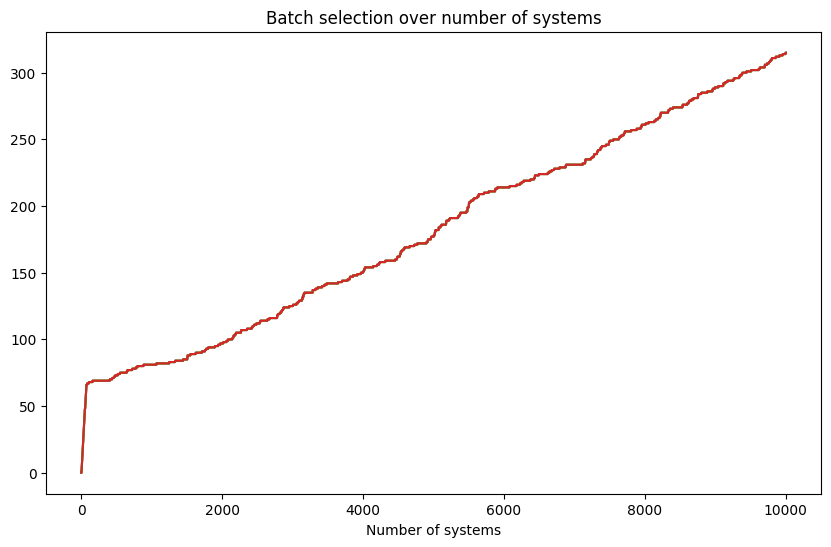

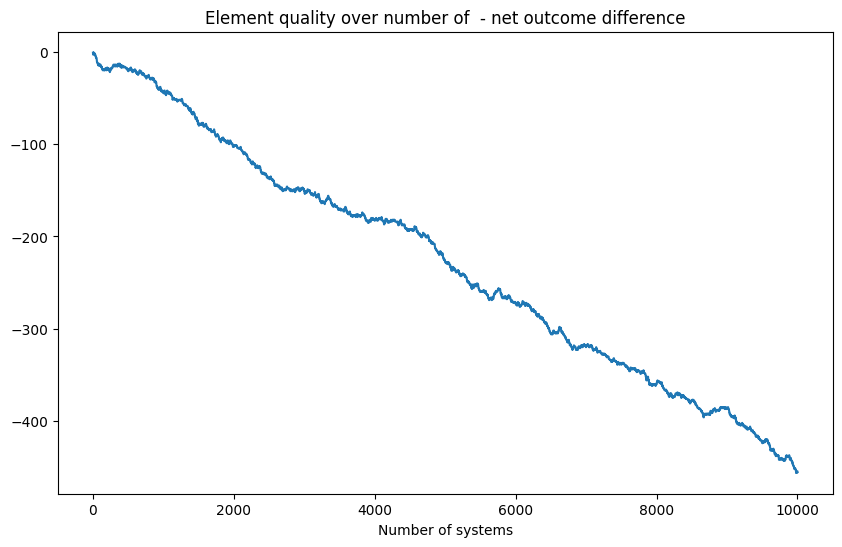

In [205]:
# If there is a diagram 'Batch selection per Bayesian choice minus per optimal choice' If I interpreted it well optimal batch should be chosen always but due to randomness
# optimal one is not always but most of it, but we want count how many times were optimal one chosen
x = np.linspace(0, NUMBER_OF_SYSTEMS, 10001)
plt.figure(figsize=(10,6))
for i, history in factory_greedy.batch_selection_history.items():
    plt.plot(x, factory_greedy.batch_selection_history[2])
plt.xlabel("Number of systems")
plt.title("Batch selection over number of systems")
plt.show()

bayesian_outcomes = np.array(factory_greedy.el_quality_history)
optimal_outcomes = np.array(factory_greedy.el_optimal_quality_history)
diff = bayesian_outcomes - optimal_outcomes

cumulative_diff = np.cumsum(diff)

plt.figure(figsize=(10,6))
plt.plot(cumulative_diff)
plt.xlabel("Number of systems")
plt.title("Element quality over number of  - net outcome difference")
plt.show()

# Upper confidence bound

If a batch has been tested very few times, the 'uncertainty bonus' is huge, so the algorithm picks it. As it is tested more, the bonus shrinks and it only gets picked if its quality is actually high

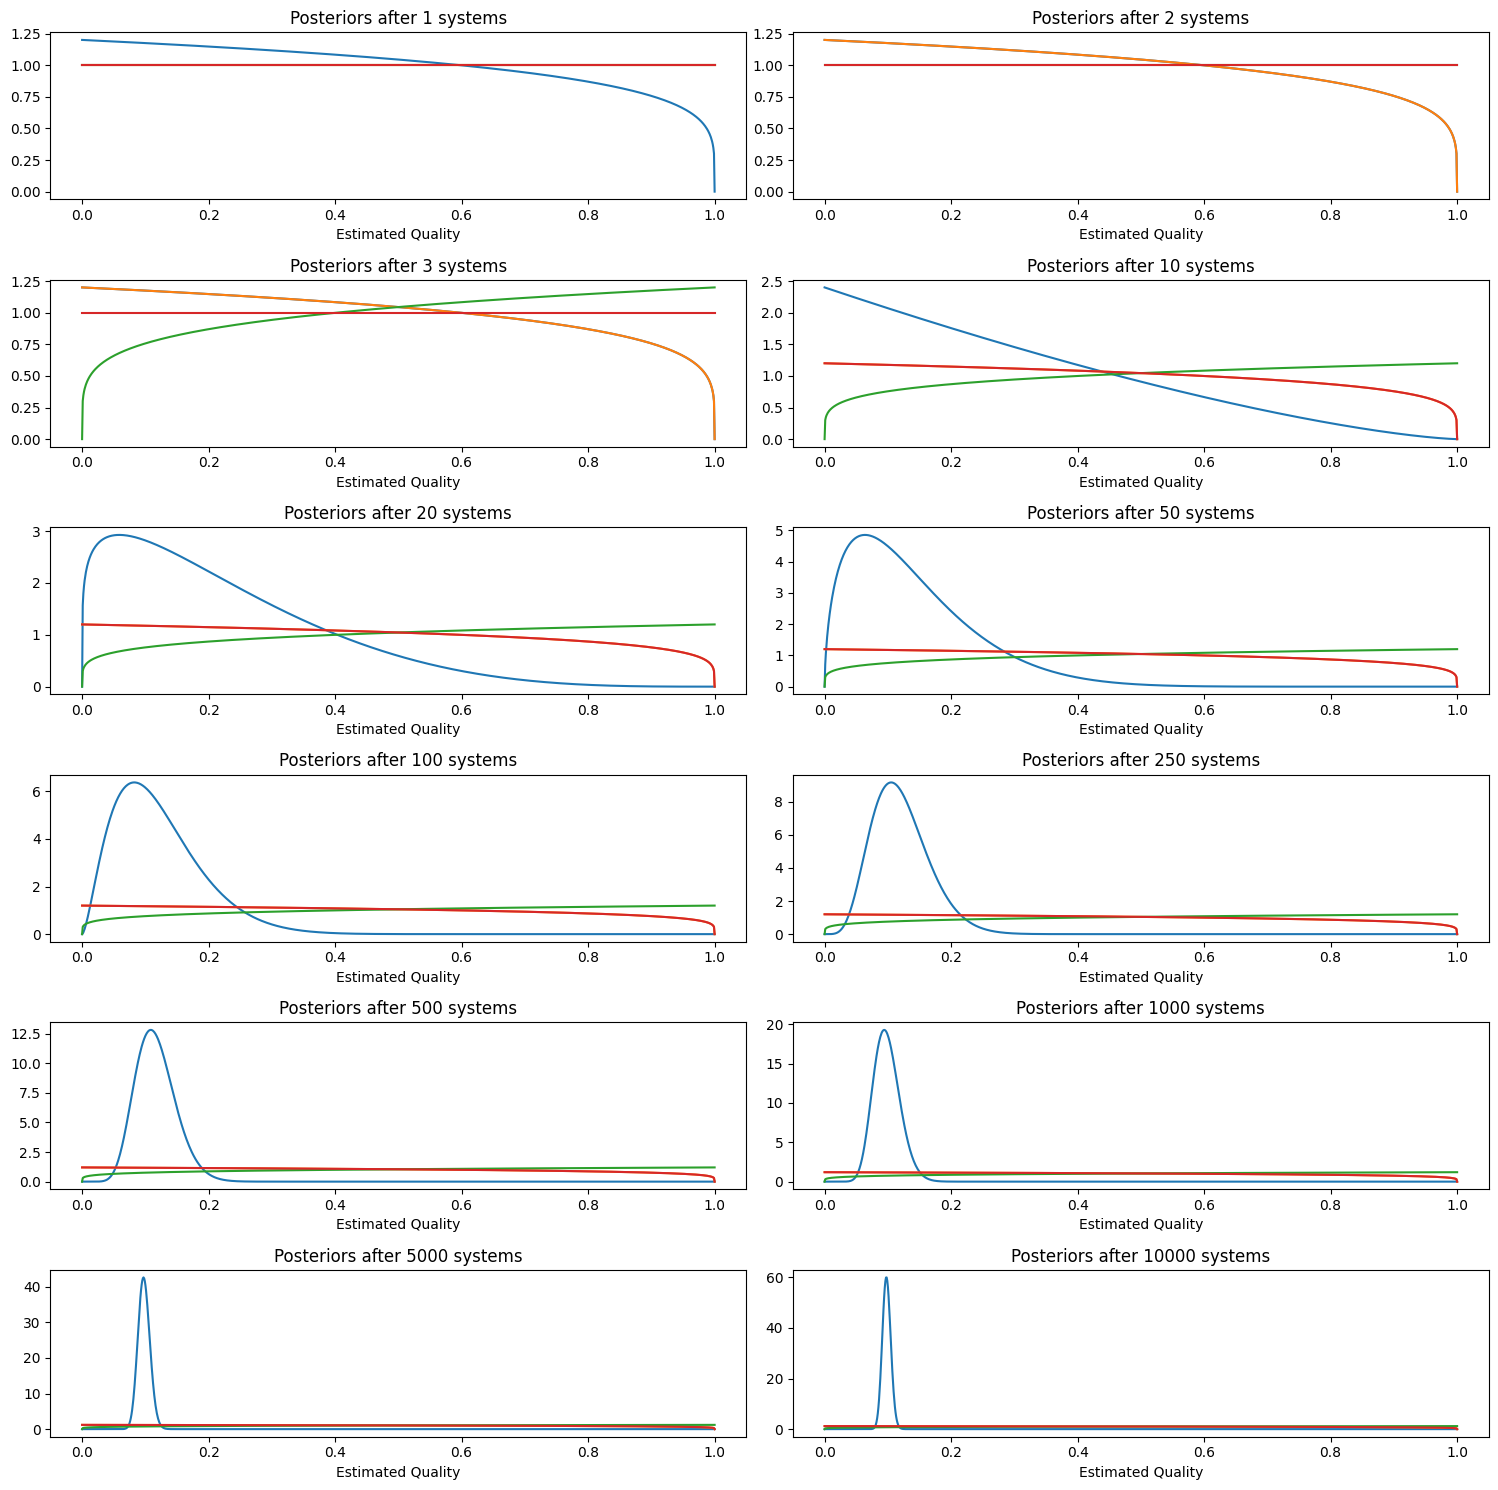

In [206]:
STRATEGY_TO_USE = "upper_conf_bound"

# Initialize Factory
factory_ucb = Factory(QUALITIES)

# Prepare Plotting
fig, axes = plt.subplots(6, 2, figsize=(15, 15))
axes = axes.flatten() # Flatten 6x2 matrix to a 1D array for easy indexing
plot_idx = 0
x_axis = np.linspace(0, 1, 1000) # probability


for system_idx in range(1, NUMBER_OF_SYSTEMS + 1):

    factory_ucb.produce_system(STRATEGY_TO_USE)

    # Check if we have to draw
    if system_idx in CHECKPOINTS:
        ax = axes[plot_idx]

        # Plot the Beta for each batch
        for i, batch in enumerate(factory_ucb.batches):
            # Calculate the curve
            y_axis = beta_dist.pdf(x_axis, batch.alpha, batch.beta)

            # Plot with a label
            ax.plot(x_axis, y_axis, label=f'Batch {i+1} (True: {batch.quality})')


        ax.set_title(f"Posteriors after {system_idx} systems")
        ax.set_xlabel("Estimated Quality")

        plot_idx += 1

plt.tight_layout()
plt.show()

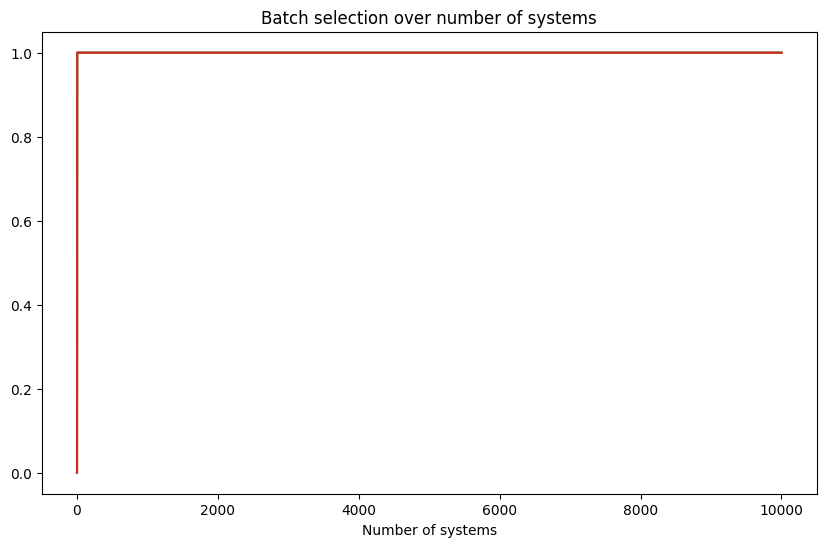

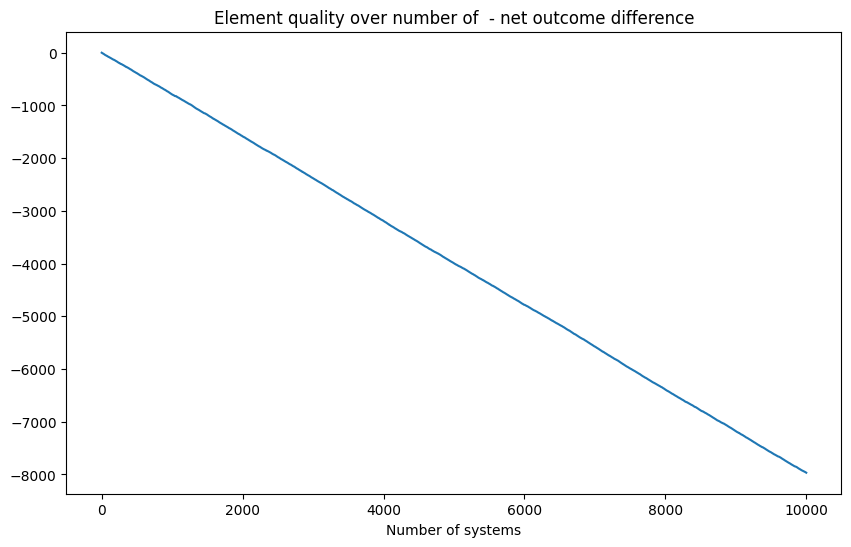

In [207]:

x = np.linspace(0, NUMBER_OF_SYSTEMS, 10001)
plt.figure(figsize=(10,6))
for i, history in factory_ucb.batch_selection_history.items():
    plt.plot(x, factory_ucb.batch_selection_history[2])
plt.xlabel("Number of systems")
plt.title("Batch selection over number of systems")
plt.show()

bayesian_outcomes = np.array(factory_ucb.el_quality_history)
optimal_outcomes = np.array(factory_ucb.el_optimal_quality_history)
diff = bayesian_outcomes - optimal_outcomes

cumulative_diff = np.cumsum(diff)

plt.figure(figsize=(10,6))
plt.plot(cumulative_diff)
plt.xlabel("Number of systems")
plt.title("Element quality over number of  - net outcome difference")
plt.show()

Few words about last result.
As the simulation runs longer and worst batch hasn't been picked the exploration bonus becomes so large that it overpowers the bad quality. That why model is one more time checking this the worst case.

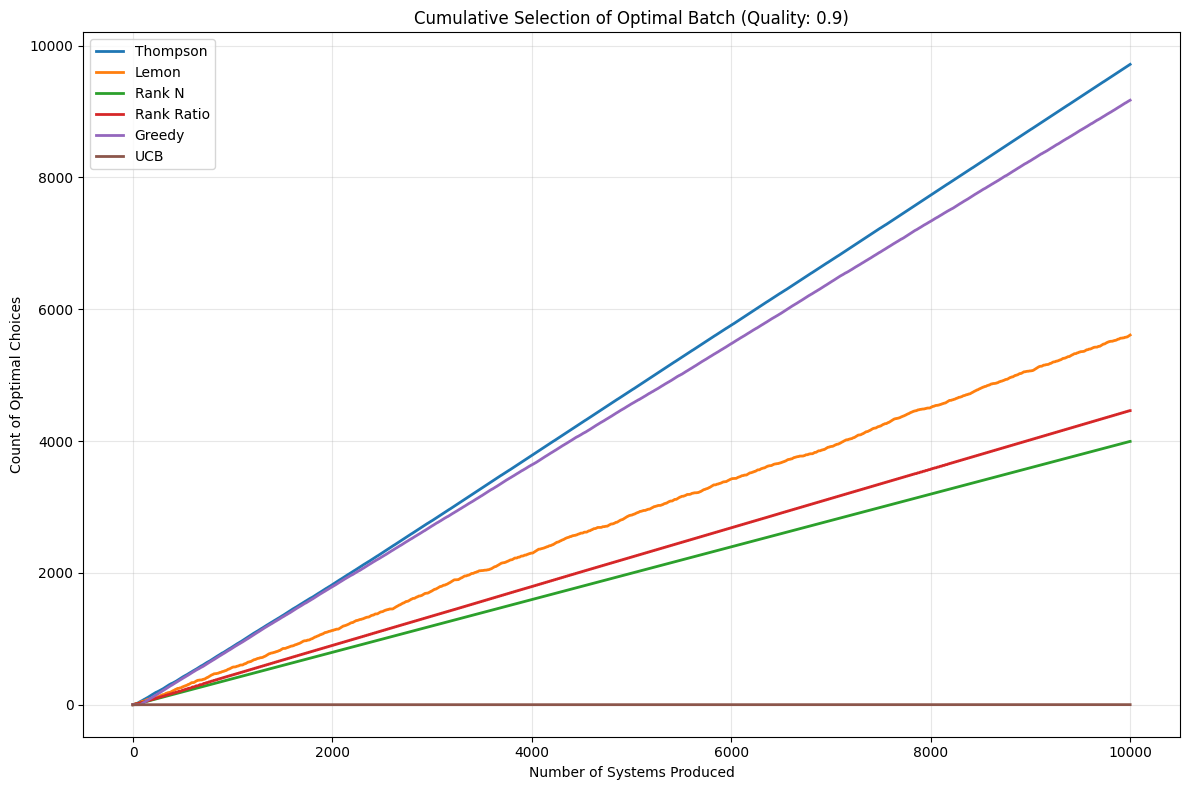

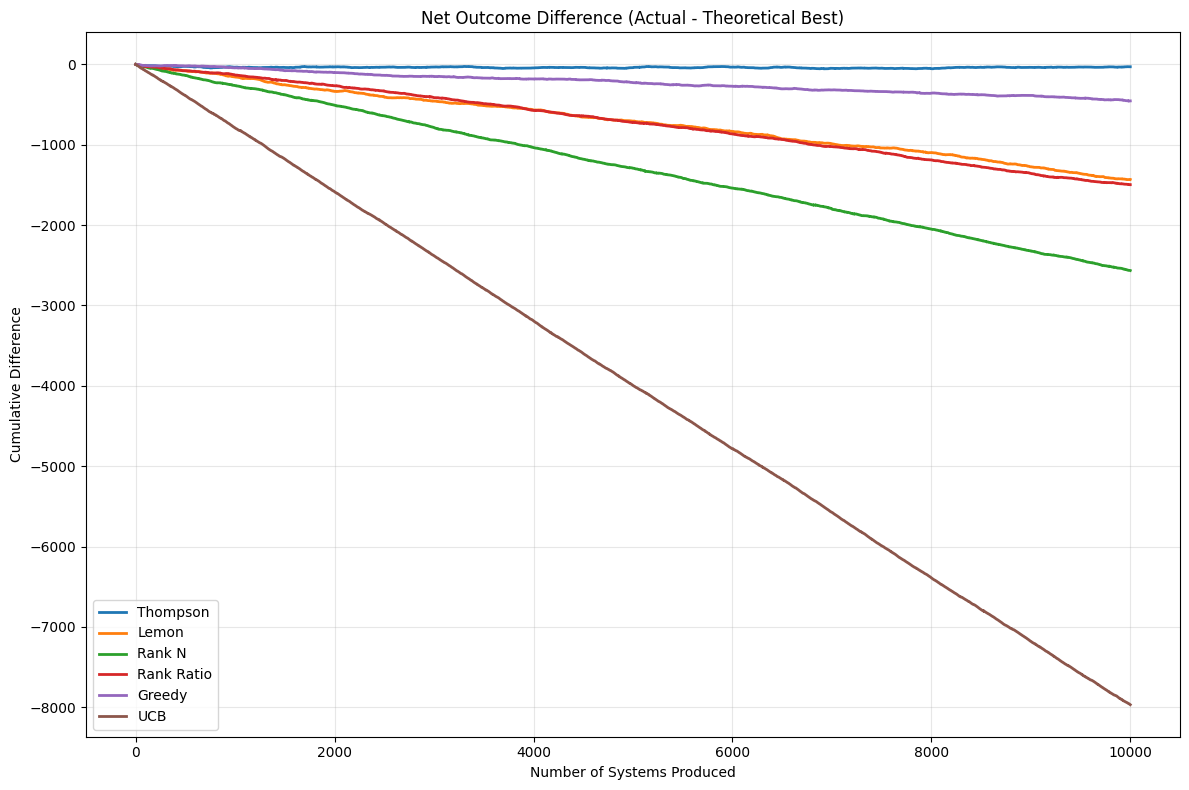

In [208]:
import matplotlib.pyplot as plt
import numpy as np

OPTIMAL_BATCH_IDX = np.argmax(QUALITIES)

# Group all factory instances for easy iteration
strategies = {
    "Thompson": factory,
    "Lemon": factory_lemon,
    "Rank N": factory_rank,
    "Rank Ratio": factory_ratio,
    "Greedy": factory_greedy,
    "UCB": factory_ucb
}

# Setup the x-axis, Ensure all factories ran for the same NUMBER_OF_SYSTEMS
x_axis = np.arange(len(factory.el_quality_history))


# CHART 1: Optimal Batch Selection Count
plt.figure(figsize=(12, 8))

for name, strat_factory in strategies.items():
    # This shows how many times the algorithm correctly identified the winner
    selection_history = strat_factory.batch_selection_history[OPTIMAL_BATCH_IDX]

    # Check length compatibility just in case
    y_data = selection_history[:len(x_axis)]

    plt.plot(x_axis, y_data, label=name, linewidth=2)

plt.title(f"Cumulative Selection of Optimal Batch (Quality: {max(QUALITIES)})")
plt.xlabel("Number of Systems Produced")
plt.ylabel("Count of Optimal Choices")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#  CHART 2: Net Outcome Difference (Performance relative to Ideal)
plt.figure(figsize=(12, 8))

for name, strat_factory in strategies.items():
    # Convert lists to numpy arrays for element-wise subtraction
    actual_outcomes = np.array(strat_factory.el_quality_history)
    ideal_outcomes = np.array(strat_factory.el_optimal_quality_history)

    # Calculate difference (Actual - Ideal), 0 means we performed exactly as well as the theoretical best
    diff = actual_outcomes - ideal_outcomes
    cumulative_diff = np.cumsum(diff)


    y_data = cumulative_diff[:len(x_axis)]

    plt.plot(x_axis, y_data, label=name, linewidth=2)

plt.title("Net Outcome Difference (Actual - Theoretical Best)")
plt.xlabel("Number of Systems Produced")
plt.ylabel("Cumulative Difference")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Simulating Gamma = 0...
Simulating Gamma = 0.01...
Simulating Gamma = 0.05...
Simulating Gamma = 0.1...
Simulating Gamma = 0.2...
Simulating Gamma = 0.5...


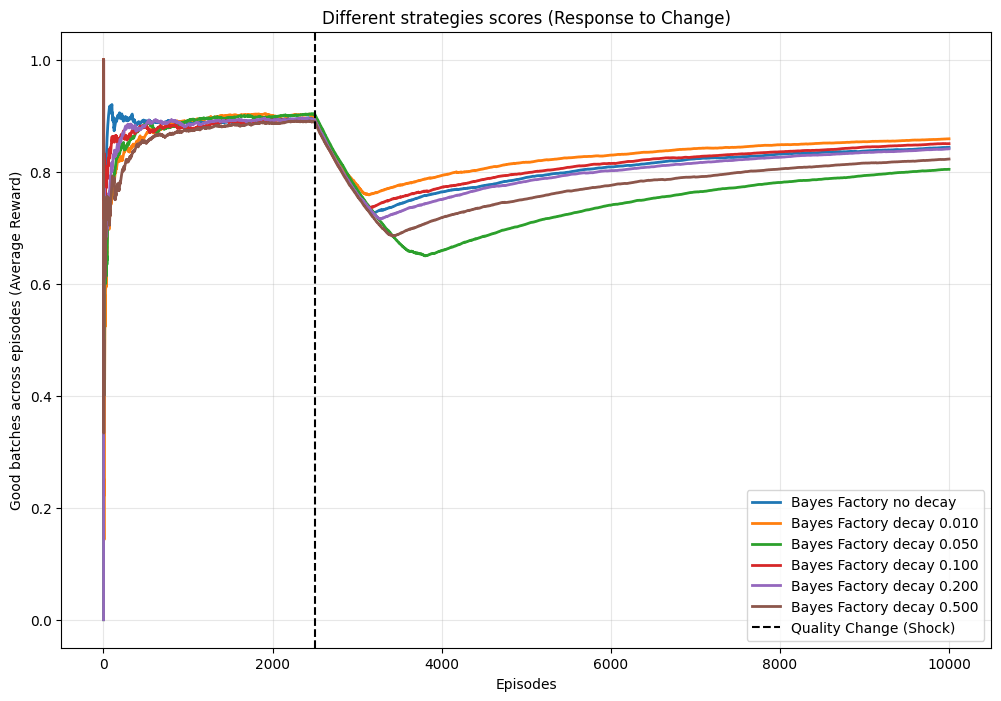

In [209]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist

# CONFIGURATION
NUMBER_OF_SYSTEMS = 10000
CHANGE_POINT = 2500
QUALITIES = [0.1, 0.25, 0.7, 0.9]
OPTIMAL_IDX = np.argmax(QUALITIES)
GAMMAS_TO_TEST = [0, 0.01, 0.05, 0.1, 0.2, 0.5] # Different memory settings


class Batch:
    def __init__(self, true_quality, gamma=1.0):
        self.quality = true_quality
        self.gamma = gamma
        self.alpha = 1.0
        self.beta = 1.0

    def sample_belief(self):
        return np.random.beta(self.alpha, self.beta)

    def produce_and_test(self):
        is_good = np.random.rand() < self.quality

        self.alpha =  self.gamma * self.alpha + (1 -  self.gamma) * (self.alpha + int(is_good))
        self.beta =  self.gamma * self.beta + (1 -  self.gamma) * (self.beta + (1 - int(is_good)))

        return is_good

class Factory:
    def __init__(self, qualities, gamma):
        self.batches = [Batch(q, gamma) for q in qualities]

        # To track cumulative score
        self.total_good_history = []


    def set_qualities(self, new_qualities):
        for i, batch in enumerate(self.batches):
            if i < len(new_qualities):
                batch.quality = new_qualities[i]

    def run_simulation(self, steps):
        cumulative_good = 0

        for t in range(1, steps+1):
            if t == CHANGE_POINT:
                new_q = [0.9, 0.7, 0.25, 0.1]
                self.set_qualities(new_q)

            # Thompson Sampling Logic
            guessed_qualities = [b.sample_belief() for b in self.batches]
            chosen_index = np.argmax(guessed_qualities)

            result = self.batches[chosen_index].produce_and_test()

            cumulative_good += int(result)
            self.total_good_history.append(cumulative_good)

# Plotting
plt.figure(figsize=(12, 8))
steps_range = np.arange(1, NUMBER_OF_SYSTEMS + 1)

# Run the experiment for each Gamma
for gamma in GAMMAS_TO_TEST:
    print(f"Simulating Gamma = {gamma}...")

    # Initialize & Run
    factory = Factory(QUALITIES, gamma=gamma)
    factory.run_simulation(NUMBER_OF_SYSTEMS)

    # Calculate "Good Batches across episodes" (Average Reward)
    # Formula: Cumulative_Good / Current_Step_Number
    y_values = np.array(factory.total_good_history) / steps_range

    # Labeling
    label_text = f"Bayes Factory {'no decay' if gamma == 0 else f'decay {gamma:.3f}'}"
    plt.plot(steps_range, y_values, label=label_text, linewidth=2)

#
plt.axvline(x=CHANGE_POINT, color='black', linestyle='--', label="Quality Change (Shock)")
plt.title("Different strategies scores (Response to Change)")
plt.xlabel("Episodes")
plt.ylabel("Good batches across episodes (Average Reward)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()